##  Quick demo of odf.sbe
In this example, we'll explore `odf.sbe` and some of the ways it can be used to quickly load files untouched by SeaBird's SBEDataProcessing software. This includes:
* .hex files --> containing all of the data in a hexadecimal format, in rows of *scan number*.
* .xmlcon files --> the deck unit and sensor package settings (including coefficients) for a cast.
* .bl files --> logs of which bottle is fired, when, and the corresponding scan numbers associated with the closure.
* .hdr files --> a header containing information defined by the science party or for post-processing.
* .mrk files --> logs of manually marking scans during data acquisition, as a way to identify interesting features for later.

Let's run through an example cast.

In [1]:
from odf.sbe.io import read_hex

In [ ]:
#   In this example, I have the .hex in the same folder as the other files.
ds = read_hex("test_data/S03C01.hex")
ds

<xarray.Dataset> Size: 2MB
Dimensions:  (scan: 53589, bytes_per_scan: 37)
Coordinates:
  * scan     (scan) int64 429kB 1 2 3 4 5 6 ... 53585 53586 53587 53588 53589
Dimensions without coordinates: bytes_per_scan
Data variables:
    hex      (scan, bytes_per_scan) uint8 2MB 19 122 122 10 ... 64 184 114 141
    xmlcon   <U10114 40kB '<?xml version="1.0" encoding="UTF-8"?>\r\n<SBE_Ins...
    bl       <U1114 4kB 'C:\\Users\\otg\\Desktop\\CTD Data\\km2206\\S03C01.bl...
    hdr      <U744 3kB '* Sea-Bird SBE 9 Data File:\r\n* FileName = C:\\Users...
    mrk      <U3013 12kB 'C:\\Users\\otg\\Desktop\\CTD Data\\km2206\\S03C01.m...

In [3]:
type(ds.hex)

xarray.core.dataarray.DataArray

By default, all non-hex files are stored inside the dataset as Xarray DataArrays of text or xml.
Using the configuration in the .xmlcon, data within each scan is broken up into respective bytes in an array. In this example, each scan contains 37 bytes and the cast was 53,589 scans in length (less than an hour).

### Engineering units
Hexadecimal data and bytes don't serve much general use until they're translated into something human-readable. SeaBird's scans are measured as frequencies or voltages, so getting these bytes into engineering units is a good step for having data legible and testable.

In [4]:
# The accessor lets you get frequencies like they are an attribute on sbe
from odf.sbe import accessors   #   This line is required to enable the sbe accessor
ds.sbe

*Accessors* allow on-the-fly calculations of the entire array using Numpy and Xarray. This is incredibly fast.

In [5]:
ds.sbe["v0"]

No ScanTimeAdded in XMLCON - building manually from frequency.


<xarray.DataArray 'hex' (scan: 53589)> Size: 429kB
array([2.9010989, 2.9010989, 2.9010989, ..., 2.9047619, 2.9035409,
       2.9047619], shape=(53589,))
Coordinates:
  * scan     (scan) int64 429kB 1 2 3 4 5 6 ... 53585 53586 53587 53588 53589

The example above is returning one of the voltage channels (the first - index 0). For this example, there are a number of potential items that can be pulled.

In [6]:
list(ds.sbe)

['f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'v0',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'latitude',
 'longitude',
 'newpos',
 'ptempC',
 'pump',
 'bct',
 'HBBotCls',
 'modem',
 'mod']

In [7]:
print(f"First reading of fourth frequency channel, F3: {ds.sbe["f3"][0].item()} at first latitude reading: {ds.sbe["latitude"][0].item()}")

First reading of fourth frequency channel, F3: 4858.84765625 at first latitude reading: 27.30804


Frequencies and voltages are converted from the `ds.hex` bytes using equations described in the SBE deck unit manual (page 39 as of 2025).

$ Frequency (f)_m = Byte_n * 256 + Byte_{n+1} + Byte_{n+2} / 256 $

Where $3*n$ = $m$ 

In the field, all frequencies are measured on the JB endcap, whereas all voltages are measured on the JT endcap.

$ Voltage (v) = 5 (1 - [N / 4095])$

Where N = 12-bit binary representation of voltage. These 12 bits are **broken up** between 3 bytes, so each A/D channel shares 4 bits with another channel.

**MSB** = "most significant bit"

**LSB** = "least significant bit"

<table>
    <tr>
        <td>Word</td>
        <td>Byte</td>
        <td>Description</td>
    </tr>
    <tr>
        <td>0</td>
        <td>0-2</td>
        <td>Primary temperature (frequency)</td>
    </tr>
    <tr>
        <td>1</td>
        <td>3-5</td>
        <td>Primary conductivity (frequency)</td>
    </tr>
    <tr>
        <td>2</td>
        <td>6-8</td>
        <td>Digiquartz pressure (frequency)</td>
    </tr>
    <tr>
        <td>3</td>
        <td>9-11</td>
        <td>Secondary temperature (frequency)</td>
    </tr>
    <tr>
        <td>4</td>
        <td>12-14</td>
        <td>Secondary conductivity (frequency)</td>
    </tr>
    <tr>
        <td>5</td>
        <td>15</td>
        <td>A/D 0 (8 MSBs)</td>
    </tr>
    <tr>
        <td>5</td>
        <td>16</td>
        <td>A/D 0 (LSBs 4-7) A/D 1 (MSB 1-3)</td>
    </tr>
    <tr>
        <td>5</td>
        <td>17</td>
        <td>A/D 1 (8 LSBs)</td>
    </tr>
    <tr>
        <td>6</td>
        <td>18</td>
        <td>A/D 2 (8 MSBs)</td>
    </tr>
    <tr>
        <td>6</td>
        <td>19</td>
        <td>A/D 2 (4 LSBs) A/D 3 (MSB 1-3)</td>
    </tr>
    <tr>
        <td>6</td>
        <td>20</td>
        <td>A/D 3 (8 LSBs)</td>
    </tr>
    <tr>
        <td>7</td>
        <td>21</td>
        <td>A/D 4 (8 MSBs)</td>
    </tr>
    <tr>
        <td>7</td>
        <td>22</td>
        <td>A/D 4 (4 LSBs) A/D 5 (4 MSB)</td>
    </tr>
    <tr>
        <td>7</td>
        <td>23</td>
        <td>A/D 5 (8 LSBs)</td>
    </tr>
    <tr>
        <td>8</td>
        <td>24</td>
        <td>A/D 6 (8 MSBs)</td>
    </tr>
    <tr>
        <td>8</td>
        <td>25</td>
        <td>A/D 6 (4 LSBs) A/D 7 (4 MSB)</td>
    </tr>
    <tr>
        <td>8</td>
        <td>26</td>
        <td>A/D 7 (8 LSBs)</td>
    </tr>
</table>

This is all dependent on what is entered into the deck unit portion of the .xmlcon file, as channels can be supressed. Items are written to the scan in a speicific order:
* Frequencies and volatages
* Surface PAR
* Nmea position, depth, and time
* SBE9 internal temperature probe, pump status, bottom contact switch and bottle fire indicator, and modulo errors
* Scan time

### XMLCON and other attributes
By default, the other files are stored inside the dataset as data variables in their unparsed form.

This is where the `parsers` module comes in handy.
* `parse_xmlcon()` --> returns two dictionaries: the deck unit settings as a `config_dict`, and the sensor package (everything plugged in) as `sensor_dict`.
* `parse_bl()` --> returns a list of dictionaries for indexing the bottle closures.
* `parse_hdr()` --> returns a dictionary of all the items logged in the .hdr file, placing non-automatic items under the "comments" key.

In [8]:
import odf.sbe.parsers as parsers

In [9]:
xmlcon_box, xmlcon_sensors = parsers.parse_xmlcon(ds.xmlcon)

In [10]:
ds.xmlcon

<xarray.DataArray 'xmlcon' ()> Size: 40kB
array('<?xml version="1.0" encoding="UTF-8"?>\r\n<SBE_InstrumentConfiguration SB_ConfigCTD_FileVersion="7.26.4.0" >\r\n  <Instrument Type="8" >\r\n    <Name>SBE 911plus/917plus CTD</Name>\r\n    <FrequencyChannelsSuppressed>0</FrequencyChannelsSuppressed>\r\n    <VoltageWordsSuppressed>0</VoltageWordsSuppressed>\r\n    <ComputerInterface>0</ComputerInterface>\r\n    <!-- 0 == SBE11plus Firmware Version >= 5.0 -->\r\n    <!-- 1 == SBE11plus Firmware Version < 5.0 -->\r\n    <!-- 2 == SBE 17plus SEARAM -->\r\n    <!-- 3 == None -->\r\n    <DeckUnitVersion>0</DeckUnitVersion>\r\n    <ScansToAverage>1</ScansToAverage>\r\n    <SurfaceParVoltageAdded>0</SurfaceParVoltageAdded>\r\n    <ScanTimeAdded>0</ScanTimeAdded>\r\n    <NmeaPositionDataAdded>1</NmeaPositionDataAdded>\r\n    <NmeaDepthDataAdded>0</NmeaDepthDataAdded>\r\n    <NmeaTimeAdded>0</NmeaTimeAdded>\r\n    <NmeaDeviceConnectedToPC>1</NmeaDeviceConnectedToPC>\r\n    <SensorArray Size="13" >\r\n      <Sensor index="0" SensorID="55" >\r\n        <TemperatureSensor SensorID="55" >\r\n          <SerialNumber>1503</SerialNumber>\r\n          <CalibrationDate>28 Jan 22</CalibrationDate>\r\n          <UseG_J>1</UseG_J>\r\n          <A>0.00000000e+000</A>\r\n          <B>0.00000000e+000</B>\r\n          <C>0.00000000e+000</C>\r\n          <D>0.00000000e+000</D>\r\n          <F0_Old>0.000</F0_Old>\r\n          <G>4.34038616e-003</G>\r\n          <H>6.37933800e-004</H>\r\n          <I>2.20439200e-005</I>\r\n          <J>2.04998009e-006</J>\r\n          <F0>1000.000</F0>\r\n          <Slope>1.00000000</Slope>\r\n          <Offset>0.0000</Offset>\r\n        </TemperatureSensor>\r\n      </Sensor>\r\n      <Sensor index="1" SensorID="3" >\r\n        <ConductivitySensor SensorID="3" >\r\n          <SerialNumber>3784</SerialNumber>\r\n          <CalibrationDate>21-Oct-21</CalibrationDate>\r\n          <UseG_J>1</UseG_J>\r\n          <!-- Cell const and series R are applicable only for wide range sensors. -->\r\n          <SeriesR>0.0000</SeriesR>\r\n          <CellConst>2000.0000</CellConst>\r\n          <ConductivityType>0</ConductivityType>\r\n          <Coefficients equation="0" >\r\n            <A>0.00000000e+000</A>\r\n            <B>0.00000000e+000</B>\r\n            <C>0.00000000e+000</C>\r\n            <D>0.00000000e+000</D>\r\n            <M>0.0</M>\r\n            <CPcor>-9.57000000e-008</CPcor>\r\n          </Coefficients>\r\n          <Coefficients equation="1" >\r\n            <G>-1.02489128e+001</G>\r\n            <H>1.52594069e+000</H>\r\n            <I>-7.82241340e-004</I>\r\n            <J>1.77653542e-004</J>\r\n            <CPcor>-9.57000000e-008</CPcor>\r\n            <CTcor>3.2500e-006</CTcor>\r\n            <!-- WBOTC not applicable unless ConductivityType = 1. -->\r\n            <WBOTC>0.00000000e+000</WBOTC>\r\n          </Coefficients>\r\n          <Slope>1.00000000</Slope>\r\n          <Offset>0.00000</Offset>\r\n        </ConductivitySensor>\r\n      </Sensor>\r\n      <Sensor index="2" SensorID="45" >\r\n        <PressureSensor SensorID="45" >\r\n          <SerialNumber>0310</SerialNumber>\r\n          <CalibrationDate>3 Feb 22</CalibrationDate>\r\n          <C1>-3.928393e+004</C1>\r\n          <C2>1.087860e+000</C2>\r\n          <C3>1.199240e-002</C3>\r\n          <D1>3.882500e-002</D1>\r\n          <D2>0.000000e+000</D2>\r\n          <T1>3.029977e+001</T1>\r\n          <T2>4.275780e-005</T2>\r\n          <T3>4.335010e-006</T3>\r\n          <T4>2.205920e-009</T4>\r\n          <Slope>0.99986000</Slope>\r\n          <Offset>-4.04530</Offset>\r\n          <T5>0.000000e+000</T5>\r\n          <AD590M>1.151000e-002</AD590M>\r\n          <AD590B>-8.749880e+000</AD590B>\r\n        </PressureSensor>\r\n      </Sensor>\r\n      <Sensor index="3" SensorID="55" >\r\n        <TemperatureSensor SensorID="55" >\r\n          <SerialNumber>5539</SerialNumber>\r\n          <CalibrationDate>10-Sep-21</CalibrationDate>\r\n          <UseG_J>

In [11]:
xmlcon_box

{'Name': 'SBE 911plus/917plus CTD',
 'FrequencyChannelsSuppressed': 0,
 'VoltageWordsSuppressed': 0,
 'ComputerInterface': 0,
 'DeckUnitVersion': 0,
 'ScansToAverage': 1,
 'SurfaceParVoltageAdded': 0,
 'ScanTimeAdded': 0,
 'NmeaPositionDataAdded': 1,
 'NmeaDepthDataAdded': 0,
 'NmeaTimeAdded': 0,
 'NmeaDeviceConnectedToPC': 1,
 'SensorArray': '',
 'SensorArraySize': 13}

In [12]:
xmlcon_sensors.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [13]:
bl, a2 = parsers.parse_bl(ds.bl.item())
bl

[{'sequence': '1',
  'position': '1',
  'time': 'Jun 08 2022 14:15:25',
  'begining': '28455',
  'ending': '28491'},
 {'sequence': '2',
  'position': '2',
  'time': 'Jun 08 2022 14:15:37',
  'begining': '28749',
  'ending': '28785'},
 {'sequence': '3',
  'position': '3',
  'time': 'Jun 08 2022 14:15:50',
  'begining': '29055',
  'ending': '29091'},
 {'sequence': '4',
  'position': '4',
  'time': 'Jun 08 2022 14:18:31',
  'begining': '32934',
  'ending': '32970'},
 {'sequence': '5',
  'position': '5',
  'time': 'Jun 08 2022 14:18:42',
  'begining': '33199',
  'ending': '33235'},
 {'sequence': '6',
  'position': '6',
  'time': 'Jun 08 2022 14:18:52',
  'begining': '33438',
  'ending': '33474'},
 {'sequence': '7',
  'position': '7',
  'time': 'Jun 08 2022 14:20:33',
  'begining': '35853',
  'ending': '35889'},
 {'sequence': '8',
  'position': '8',
  'time': 'Jun 08 2022 14:20:43',
  'begining': '36102',
  'ending': '36138'},
 {'sequence': '9',
  'position': '9',
  'time': 'Jun 08 2022 14:

In [14]:
print(f"Niskin sequence {bl[5]['sequence']} (bottle rosette #{bl[5]['position']}) fired {bl[5]['time']}.")

Niskin sequence 6 (bottle rosette #6) fired Jun 08 2022 14:18:52.


In [15]:
hdr_dict = parsers.parse_hdr(ds.hdr.item())
hdr_dict

{'Data File': '9',
 'FileName': 'C:\\Users\\otg\\Desktop\\CTD Data\\km2206\\S03C01.hdr',
 'Software Version': 'Seasave V 7.26.7.107',
 'Temperature SN': '1503',
 'Conductivity SN': '3784',
 'Number of Bytes Per Scan': '37',
 'Number of Voltage Words': '4',
 'Number of Scans Averaged by the Deck Unit': '1',
 'System UpLoad Time': 'Jun 08 2022 13:55:39',
 'NMEA Latitude': '27 18.48 N',
 'NMEA Longitude': '160 54.82 W',
 'NMEA UTC (Time)': 'Jun 08 2022  13:55:39',
 'Store Lat/Lon Data': 'Append to Every Scan',
 'number of scans to average': '1',
 'pressure baud rate': '9600',
 'NMEA baud rate': '4800',
 'GPIB address': '1',
 'System UTC': 'Jun 08 2022 13:55:39',
 'comments': 'SBE 11plus V 5.2\nautorun on power up is disabled\nS>\nShip:\nStation:\nOperator:'}

### META accessors
Given that engineering units and metadata are highly desirable, all data can be converted using `serialize()`, which updates the dataset with new, derived data variables.

In [16]:
my_data = ds.sbe.serialize()
my_data

<xarray.Dataset> Size: 9MB
Dimensions:    (scan: 53589, bytes_per_scan: 37)
Coordinates:
  * scan       (scan) int64 429kB 1 2 3 4 5 6 ... 53585 53586 53587 53588 53589
Dimensions without coordinates: bytes_per_scan
Data variables: (12/27)
    hex        (scan, bytes_per_scan) uint8 2MB 19 122 122 10 ... 64 184 114 141
    xmlcon     <U10114 40kB '<?xml version="1.0" encoding="UTF-8"?>\r\n<SBE_I...
    bl         <U1114 4kB 'C:\\Users\\otg\\Desktop\\CTD Data\\km2206\\S03C01....
    hdr        <U744 3kB '* Sea-Bird SBE 9 Data File:\r\n* FileName = C:\\Use...
    mrk        <U3013 12kB 'C:\\Users\\otg\\Desktop\\CTD Data\\km2206\\S03C01...
    f0         (scan) float64 429kB 4.986e+03 4.986e+03 ... 5.103e+03 5.102e+03
    ...         ...
    ptempC     (scan) uint16 107kB 2981 2981 2981 2981 ... 2951 2951 2951 2951
    pump       (scan) bool 54kB False False False False ... False False False
    bct        (scan) bool 54kB True True True True True ... True True True True
    HBBotCls   (scan) bool 54kB False False False False ... False False False
    modem      (scan) bool 54kB False False False False ... False False False
    mod        (scan) uint8 54kB 57 58 59 60 61 62 ... 136 137 138 139 140 141

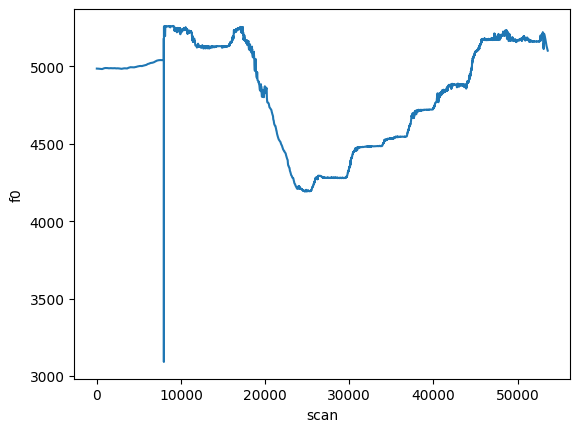

In [17]:
#   Primary temperature - Making it easy to see when the sensor package hits the water
my_data["f0"].plot(label="f0")

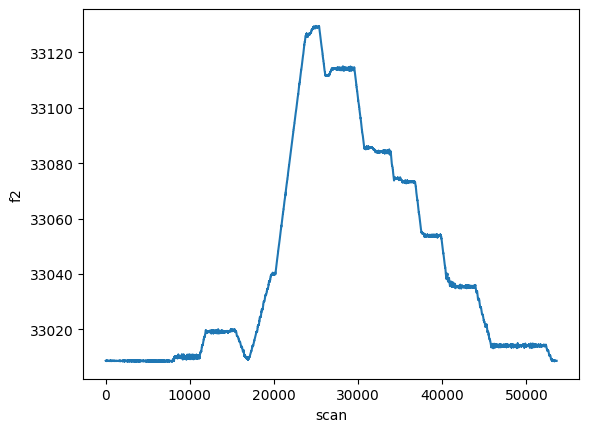

In [18]:
#   Pressure - the initial soak period and each bottle stop is visible.
my_data["f2"].plot(label="f2")